<img src="images/banner.png" align="left">

# Introduction

This notebook walks through some of the basic functions we have developed to support the readout of two-thousand, multiplexed superconducting detectors. This work is part of a broader effort in Ben Mazin's group at UCSB to develop instruments featuing arrays of cryogenic detectors for astronomy imaging applications. Check out our [lab website](https://web.physics.ucsb.edu/~bmazin/) to learn more about the whole research group. To learn more about the FPGA project, check out our [latest update on arXiv](https://arxiv.org/abs/2203.16520) or visit poster 170 at FCCM22.

# Table of Contents
A
B
C
.
.
.

# 1. System Overview

The full superconducting detector readout system block design is shown below. In this demonstration notebook, we will be showcasing the DAC Replay, OPFB, Bin Select, and Calibration Capture systems which are highlighted in yellow. All of these IP blocks are implemented with a combination of Vitis High-Level Syntheis and pre-existing Xilinx IP available in Vivado IPI. The one exception is the capture subsystem which uses an [open source RTL core](https://github.com/MazinLab/wb2axip/tree/master) to convert AXIS to AXI burst writes to the MIG because as far as we can tell this is not possible with HLS as of version 2021.1.

<img src="images/full_block_design.png" alt="drawing" width="600"/>

## 1.1 Hardware Setup

To fully run this notebook, you will need to have a ZCU111 with the XM500 Balun card attached. Connect ADC XXX to DAC XXX and ADC XXX .

***Picutre of Board in Loopback (label ADC and DAC ports)***

## 1.2 Overlay Design

The overlay design is built in Vivado 2021.2. The design sources all clocks from the RFDC ADC and DAC tile PLL's. All optional resets in the design have been tied off to improve timing performance and resource utilization. Note the RFDC, DAC Replay, and MIG blocks require functioning resets. 

<img src="images/overlay.png" alt="drawing" width="990"/>

## 1.3 Imports, Download Overlay

In [1]:
import logging
logging.basicConfig()
logging.getLogger('mkidgen3').setLevel('DEBUG')
import pynq
import time
from pynq import PL

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc

In [2]:
# Download Overlay, Optionally Configure Clocks
ol = g3.configure('fccm22_demo.bit', clocks=True, external_10mhz=True, ignore_version=True)

INFO:mkidgen3:PL Bitfile: /home/xilinx/jupyter_notebooks/fccm22_demo/fccm22_demo.bit (2022/5/9 17:46:26 +112764)  Loaded: True


# 2. IP Blocks

The demo overlay contains four major IP subsystems: DAC Replay, OPFB, Bin Select, and Capture. The remainder of this notebook will walk you through the IP we have developed and how to use them.

## 2.1 DAC Replay
The DAC Replay is a Vitis HLS IP. The source code along with the exported IP is available [here](https://github.com/MazinLab/dac-replay/tree/master). The DAC Replay IP is implemented as a 60 URAM look-up-table which totals 2MiB of waveform data. The URAM is programmed with 2^19 complex values where the real and complex parts are each 16-bits. The real and complex signal components are fed to two RFSoC DACs each running at 4.096 GSPS. This allows us to generate arbitrary waveforms in the [-2048 MHz, 2048 MHz) range with 4.096 GHz / 2^19 =  7.8125 KHz resolution. 

The DAC Replay IP supports replaying all 2^19 samples in a loop or a smaller (integer multiple of 16) range of samples. The IP also supports generating a TLAST signal on a group of 16 samples. The IP outputs two 256-bit AXI-4 streams at 256 MHz, one feeds the I DAC and the other the Q DAC. An example of the AXI4-Stream format for the real data (I DAC) is shown below. 


In [ ]:
import nbwavedrom as wd

In [ ]:
wd.draw({
'signal': [
  {'name': 'clk', 'wave': 'p.....|...'},
  {'name': 'tlast', 'wave': '0.10...'},
  {'name': 'data[0:15]', 'wave': 'x.345x|=x', 'data': ['i_33', 'i_16','i_0','idata']},
  {'name': 'data[16:32]', 'wave': 'x.345x|=x', 'data': ['i_34', 'i_17','i_1','idata']},
  {'name': 'data[33:49]', 'wave': 'x.345x|=x', 'data': ['i_35', 'i_18','i_2','idata']},
  {'name': 'data[50:66]', 'wave': 'x.345x|=x', 'data': ['i_36', 'i_19','i_3','idata']},
  {},
  {'name': 'data[239:255]', 'wave': 'x.345x|=x', 'data': ['i_49', 'i_32','i_15','idata']},
]})

The core is programmed over AXI4-Lite using the DAC Replay Python driver availbale [here](https://github.com/MazinLab/MKIDGen3/blob/develop/mkidgen3/drivers/dactable.py). This core is nominally used to feed two RFSoC DACs but it is also possible to stream data to other DSP logic within the FPGA fabric to test IP subsystems with data manufactured in Python. Please contact the authors to learn more about this use case.

### DAC Waveform

The following cells demonstrate how to construct an arbitrary waveform and play it out of the DACs.

In [62]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([300e6, 300.5e6])
amplitudes = np.ones_like(tones)/tones.shape[0]
snr = 'max'

In [63]:
Ns=2**19 # fill the DAC LUT Table
in_noise = 0
if snr != 'max':
    a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10)
    in_noise = np.sqrt(a_noise)*(np.random.uniform(-1,1,size=Ns) + 1j*np.random.uniform(-1,1,size=Ns))

In [64]:
# Compute the waveform
dactable = generate_dac_comb(frequencies=tones, n_samples=Ns, sample_rate=4.096e9, amplitudes=amplitudes)
if snr != 'max':
    dactable['iq']+=in_noise
    dactable['iq']/=max(dactable['iq'].real, dactable['iq'].imag)
    pass

In [65]:
# Program URAM and run DAC Table
if ol.dac_table_axim_0.register_map.run.run:
    ol.dac_table_axim_0.stop()
ol.dac_table_axim_0.replay(dactable['iq'], fpgen='simple')

At this point, you should be able to measure the DAC output using a Spectrum Analyzer or Oscilloscope. You can also use the RFSoC ADCs! Keep scrolling to see how.

### Capture & Plot DAC Output Using RFSoC ADCs

With the ZCU111 connected in loopback, we can sample the DAC output with the RFSoC ADCs and capture the result to the PL DRAM where we can visualize it in this notebook.

In [66]:
N = Ns # Number of samples to capture (full waveform)
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)
#time = np.linspace(0, Tc, N) # Time vector (seconds)

In [76]:
# Trigger Capture
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V

DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500800000 from source adc


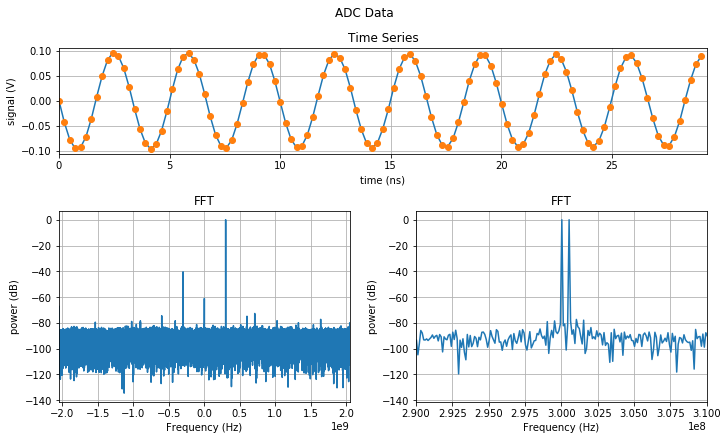

In [80]:
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (2.9e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom, figsize=(10, 6))

### QMC Correction

In the plots above, you may have noticed we generated the frequencies desired, but we also generated image tones on the other half of the spectrum. This is due to slight gain, phase, and offset imbalances in the I and Q ADCs and DACs. As is, there should be a ~40 dB offset. This is good enough for our application (and most) but it is possible to use the built-in QMC circuit to try to correct for these imbalances. The figure below is copied from [PG269 page v2.4 page 140](https://docs.xilinx.com/v/u/2.4-English/pg269-rf-data-converter).

<img src="images/qmc.png" alt="drawing" width="500"/>

In this design the I DAC is dac(1,3) and the Q DAC is dac(1,4).

In [31]:
ol.rfdc.set_qmc(dac=(1,3), gain=0.5)

Setting DAC Tile 1, Block 3


{'EnableGain': 0,
 'EnablePhase': 0,
 'EventSource': 0,
 'GainCorrectionFactor': 0.0,
 'OffsetCorrectionFactor': 0,
 'PhaseCorrectionFactor': 0.0}

In [32]:
# Trigger another ADC Capture
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V

DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500400000 from source adc


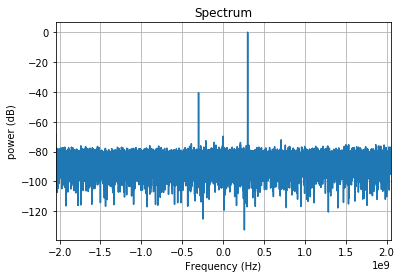

In [75]:
# Plot ADC Capture
mkidgen3.plotting.plot_adc_fft(adc_capture_data, fs=4.096e9, db=True, fft_points=2**14, xlim=(-2.048e9,2.048e9), ylim=None, ax=None)

As you may have discovered the QMC is very sensitive. It's hard to do better than 40 dB-- almost any noticable change will make it much worse!

In [81]:
# Return to Default Settings
ol.rfdc.set_qmc(dac=(1,3))

Setting DAC Tile 1, Block 3


{'EnableGain': 0,
 'EnablePhase': 0,
 'EventSource': 0,
 'GainCorrectionFactor': 0.0,
 'OffsetCorrectionFactor': 0,
 'PhaseCorrectionFactor': 0.0}

### 1.2.2 Oversampled Polyphase Filter Bank (OPFB)

The OPFB is a 4,096-channel, 2/1 oversampled 4 GHz channelizer. It takes in 2, 4.096 GSPS data streams--one from and I ADC and the other from a Q ADC, and produces 4096 2 MHz channels which overlap by 50%. This overlapping feature insures that no matter where a signal exists in-band, it will be able to pass through the channelizer un-attenuated. This IP is the subject of [this publication](https://ieeexplore.ieee.org/document/9336352) and is also documented in a [stand-alone git repo](https://github.com/MazinLab/RFSoC_OPFB).

After being sampled by the ADCs, we can run the data through the OPFB IP and capture the result to the PPL DDR4 for visualization.

## OPFB Capture

<script src="https://cdnjs.cloudflare.com/ajax/libs/wavedrom/2.6.8/skins/default.js" type="text/javascript"></script>
<body onload="WaveDrom.ProcessAll()">
<script type="WaveDrom">
{ signal : [
  { name: "clk",  wave: "p......" },
  { name: "bus",  wave: "x.34.5x",   data: "head body tail" },
  { name: "wire", wave: "0.1..0." },
]}
</script>

In [ ]:
# Capture N samples from all 4096 OPFB Bins
opfb_raw = g3.capture_opfb(1024, raw=True)
# Convert to complex numbers
opfb_fp = opfb_raw[..., 0] + 1j*(opfb_raw[..., 1])

In [ ]:
# Bin Offset Correction (Author's are working to fix)
opfb_shifted = np.roll(opfb_fp, 16, axis=1)

# Plot OPFB

In [ ]:
from mkidgen3.dsp import opfb_bin_spectrum, opfb_bin_freq

In [ ]:
def plot_opfb_bins(data, bins, fine_fft_shift = True, fft_shift = True, left_snip=0, ol=True):
    """
    Inputs:
    - data: Raw data out of OPFB. Should be in the form N x 4096 where N is the number of samples from a single bin.
    - bins: list of OPFB bins 0 to 4095 (note bin 0 is far left in the +/- 2 GHz spectrum).
    - fine_fft_shift: boolean. To apply an fft shift to the fine fft spectrum of each bin or not. (You should.)
    - fft_shift: boolean. To apply an fft shift to the entire OPFB output spectrum or not. (You should.)
    - ol: To plot the bins as overlapping or discard the overlap region."""

    if fft_shift:
        data = np.fft.fftshift(data, axes=1)
    bin_freqs=opfb_bin_freq(bins, data.shape[0])
    spectra=opfb_bin_spectrum(data,bins)

    sl = slice(data.shape[0]//3, -data.shape[0]//3) if not ol else slice(0,-1)
    plt.plot(bin_freqs[sl], spectra[sl])
    return bin_freqs[sl], spectra[sl]

In [ ]:
all_bins = np.linspace(0,4095,4096).astype(int).tolist()

In [ ]:
plt.subplot(211)
plot_opfb_bins(opfb_shifted,[2347,2348,2349,2350]);
plt.subplot(212)
plot_opfb_bins(opfb_shifted,[2347,2348,2350]);


In [ ]:
plot_opfb_bins(opfb_shifted,all_bins)

### 1.2.3 Bin Select

The bin select block is a Vitis HLS IP. The source code along with the exported IP is available [here](https://github.com/MazinLab/opfb-bin-to-res/tree/2021.1). The bin select block caches 8 full spectra from the 4,096-bin channelizer and assigns up to 2048 output bins to user defined channels. The user programs the core over AXI4-Lite to tell it which of the 4096 input OPFB bins to map to which of the 2048 output channels with arbitrary mapping. An example of how we might program the bin select block is shown in the figure below.

<img src="images/Bin_Select_Notebookl.png" alt="drawing" width="600"/>